# Emergency – (911) Calls: Exploratory Data Analysis (EDA).

# Prerequisites:

#### Importing the Python Libraries:

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
sns.set(rc={"figure.figsize":(12, 7)}, style="darkgrid", context="paper", font_scale=1.4)

#### Importing the Data:

In [5]:
calls = pd.read_csv("Desktop/911.csv", usecols=[*range(0, 9)])
calls.head(4)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1


#### Summary of Dataset:

In [6]:
print("Rows     : {}".format(calls.shape[0]))
print("Columns  : {}".format(calls.shape[1]))
print("\nFeatures : {}".format(calls.columns.tolist()))
print("\nMissing values : {}".format(calls.isnull().values.sum()))
print("\nUnique values : \n{}".format(calls.nunique()))

Rows     : 645716
Columns  : 9

Features : ['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'twp', 'addr', 'e']

Missing values : 78505

Unique values : 
lat           25756
lng           25786
desc         645480
zip             201
title           147
timeStamp    623574
twp              68
addr          40981
e                 1
dtype: int64


# PART A: (Data Cleaning).

#### TASK 1 – Drop (redundant/unnecessary) Columns from the DataFrame.

In [7]:
# -> Dropped ["e"] because it's (insignificant) and also a (Dummy) Variable - (always 1)!
calls.drop(columns=["e"], axis=1, inplace=True)

#### TASK 2 – Deal with Missing Values.

In [8]:
# -> Replaced NAN values for ["zip"] with '00000' after (recognising) some countries do not use these codes!
calls.fillna({"zip": "00000"}, inplace=True)
calls[calls.isna().any(axis=1)]
calls.dropna(how="any", inplace=True) # -> ["twp"] cannot be missing so drop all Rows with missing Values!

#### TASK 3 – Scrub for Duplicate data, if any. Removing duplicates to get a (clean) Dataset.

In [9]:
# -> Dropped (236) duplicate Rows from the DataFrame!
calls.duplicated().sum()
calls.drop_duplicates(keep="first", inplace=True)

#### TASK 4 – Validate if Columns are of the (correct) Type.

In [10]:
# -> ["timeStamp"] needs to be converted into a proper (DateTime) Object!
calls.dtypes

lat          float64
lng          float64
desc          object
zip           object
title         object
timeStamp     object
twp           object
addr          object
dtype: object

#### TASK 5 – Convert 'timeStamp' into a proper (DateTime) Object, then (Split) into different columns: [Hour, Date, Day of week, Month, Year].

In [11]:
calls.timeStamp = pd.to_datetime(calls.timeStamp)

calls["Hour"] = calls.timeStamp.apply(lambda x: x.hour)
calls["Date"] = calls.timeStamp.apply(lambda x: x.date())
calls["DayOfWeek"] = calls.timeStamp.apply(lambda x: x.dayofweek)
calls["Month"] = calls.timeStamp.apply(lambda x: x.month)
calls["Year"] = calls.timeStamp.apply(lambda x: x.year)

dmap = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
mmap = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

calls.DayOfWeek = calls.DayOfWeek.map(dmap)
calls.Month = calls.Month.map(mmap)

#### TASK 6 – Segregate 'timeStamp' into a Day/Night time basis.

In [12]:
# -> Day if (before) 18:00 and Night (after) 18:00!
calls["Day/Night"] = calls.timeStamp.apply(lambda x: "Night" if int(x.strftime("%H")) >= 18 else "Day")

#### Extras – Time span of the Dataset.

In [13]:
from dateutil import relativedelta

min_date = calls.timeStamp.min()
max_date = calls.timeStamp.max()
diff = relativedelta.relativedelta(pd.to_datetime(max_date), pd.to_datetime(min_date))

print("Start Date: {}".format(min_date))
print("End Date: {}".format(max_date))
print("Dataset Timespan: {} years and {} months".format(diff.years, diff.months))

Start Date: 2015-12-10 14:39:21
End Date: 2020-06-08 13:14:43
Dataset Timespan: 4 years and 5 months


# PART B: (Data Exploration & Visualization).

#### QUESTION 1 – Top 10 (Townships) for Calls?

In [14]:
top_10_twps = calls.twp.value_counts()
print(top_10_twps.head(10))

LOWER MERION        54185
ABINGTON            38909
NORRISTOWN          36454
UPPER MERION        35078
CHELTENHAM          29754
POTTSTOWN           26540
UPPER MORELAND      22271
LOWER PROVIDENCE    21827
PLYMOUTH            19524
UPPER DUBLIN        18429
Name: twp, dtype: int64


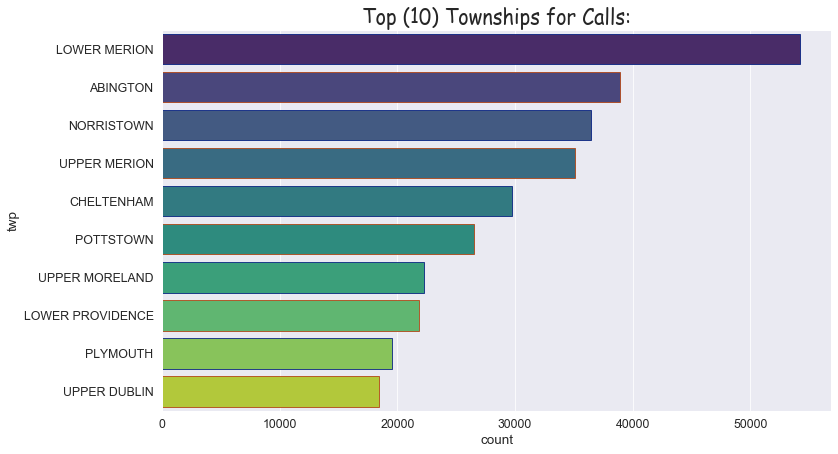

In [15]:
plt.title("Top (10) Townships for Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(y=calls.twp, order=top_10_twps.index[:10], edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);

In [16]:
# -> (Most) calls came from Township 'Lower Merion' followed by 'Abington' then 'Norristown'.

#### QUESTION 2 – Top 10 (Zipcodes) for Calls?

In [17]:
top_10_zipcodes = calls.zip.value_counts()
print(top_10_zipcodes.head(10))

00000      78026
19401.0    44214
19464.0    42612
19403.0    33920
19446.0    31311
19406.0    21851
19002.0    20554
19468.0    18474
19046.0    17429
19454.0    17193
Name: zip, dtype: int64


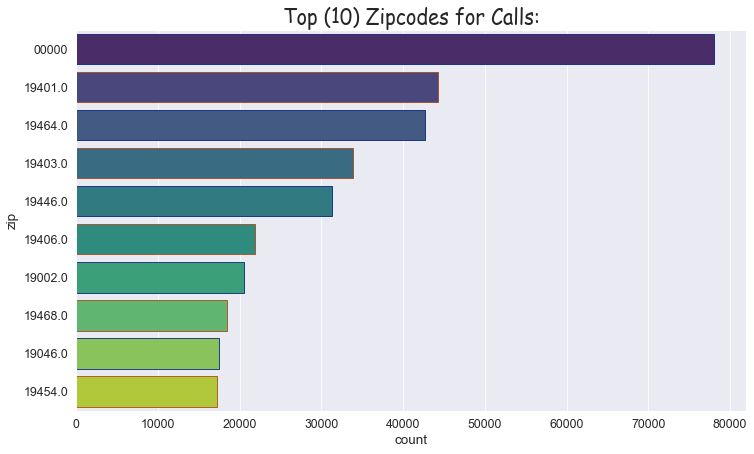

In [18]:
plt.title("Top (10) Zipcodes for Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(y=calls.zip, order=top_10_zipcodes.index[:10], edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);

In [19]:
# -> (Most) calls originated from zipcode '00000' (which i created) followed by '19401' then '19464'.

#### QUESTION 3 – Top 10 (Stations) for Calls?

In [20]:
calls["station_code"] = calls.desc.str.split("Station", expand=True)[1].str.split(";", expand=True)[0]
calls["station_code"] = calls.station_code.str.replace(":", "").str.strip()

top_10_stations = calls.station_code.value_counts()
print(top_10_stations.head(10))

308A    24512
329     21211
313     19784
381     15511
345     14033
308     13512
351     12402
317     11791
345B    11777
382     10842
Name: station_code, dtype: int64


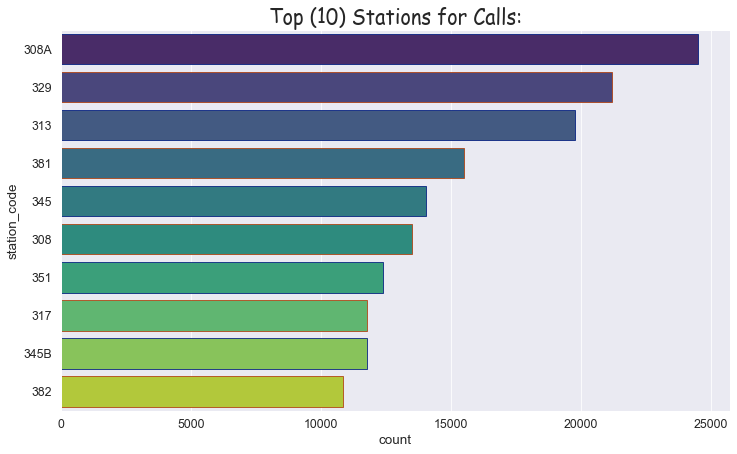

In [21]:
plt.title("Top (10) Stations for Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(y=calls.station_code, order=top_10_stations.index[:10], edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);

In [22]:
# -> Station '308A' received the (most) emergency calls followed by Station '329' then Station '313'.

#### QUESTION 4 – Top 10 (Dates) for Calls, across all (Years)?

In [23]:
top_10_dates = calls.Date.value_counts()
print(top_10_dates.head(10))

2018-03-02    2187
2018-11-15    1662
2020-06-03    1400
2018-03-07     920
2018-03-03     917
2016-01-23     887
2019-11-01     877
2019-07-11     769
2020-01-18     706
2019-02-25     690
Name: Date, dtype: int64


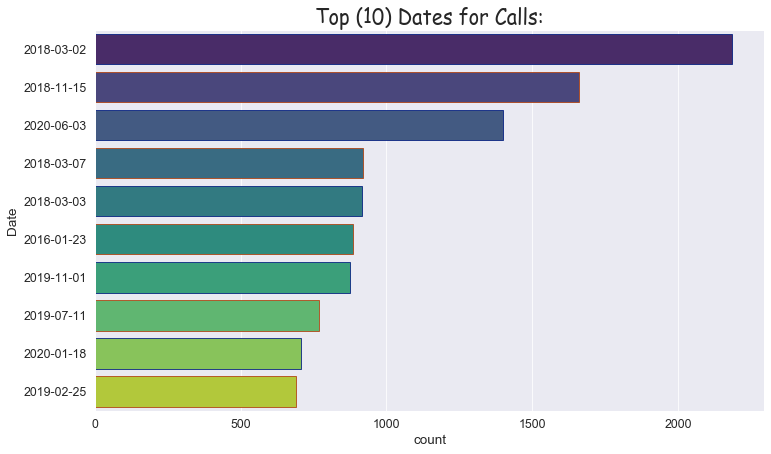

In [24]:
plt.title("Top (10) Dates for Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(y=calls.Date, order=top_10_dates.index[:10], edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);

In [25]:
# -> Busiest (Day) across all the Years is (2nd March).

#### QUESTION 5 – Most common Reason (type) for Calls?

In [26]:
calls["reason_type"] = calls.title.apply(lambda x: x.split(":")[0])

reason_types = calls.reason_type.value_counts()
print(reason_types)

EMS        322577
Traffic    225117
Fire        97504
Name: reason_type, dtype: int64


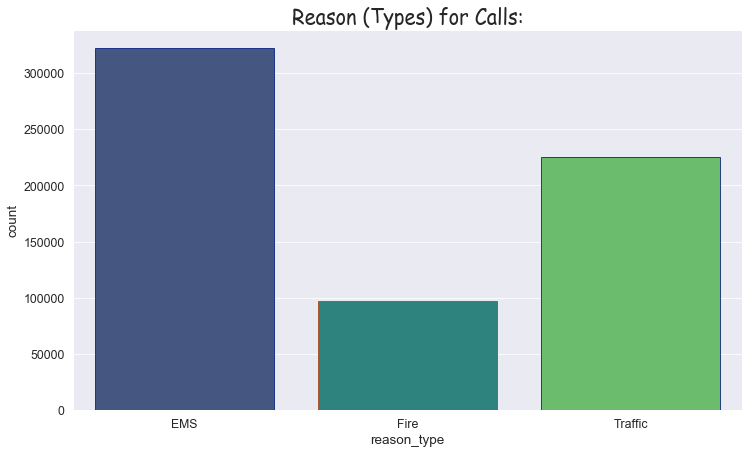

In [27]:
plt.title("Reason (Types) for Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(x=calls.reason_type, edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);

In [28]:
# -> Calls are mostly 'EMS' (emergency medical services) related followed by 'Traffic' then 'Fire'.

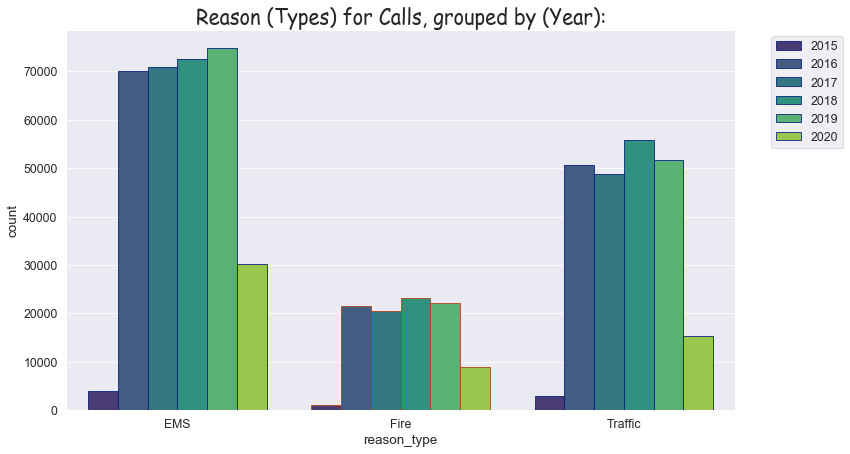

In [30]:
plt.title("Reason (Types) for Calls, grouped by (Year):", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(x=calls.reason_type, hue=calls.Year, edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);
plt.legend(bbox_to_anchor=(1.17, 1));

In [31]:
# -> (2016–2019) appear to have very similar distributions, except for in 2015 and 2020.
# -> Our Dataset only contains (1 month) of 2015 and (6 months) of 2020, and so is (incomplete).

#### QUESTION 6 – Most common (Reason) type, based on each (Day) of the Week?

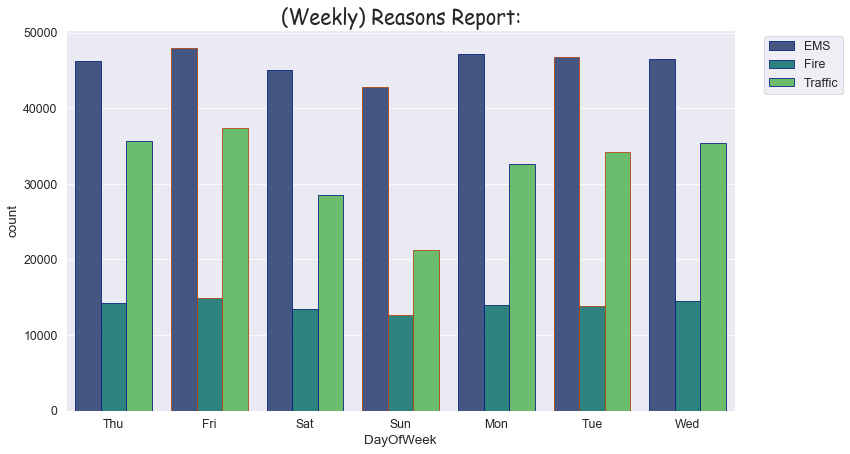

In [32]:
plt.title("(Weekly) Reasons Report:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(x=calls.DayOfWeek, hue=calls.reason_type, edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);
plt.legend(bbox_to_anchor=(1.17, 1));

In [33]:
# -> Calls are almost (equal) on all days. Also, (most) calls occur on (Friday's).
# -> Traffic related calls are (Low) during the (Weekend), which makes sense.
# -> EMS related calls are also (Low) during the (Weekend). Hypothesis: people prefer to spend the weekend indoors?

#### QUESTION 7 – Most common (Reason) type, based on each (Month)?

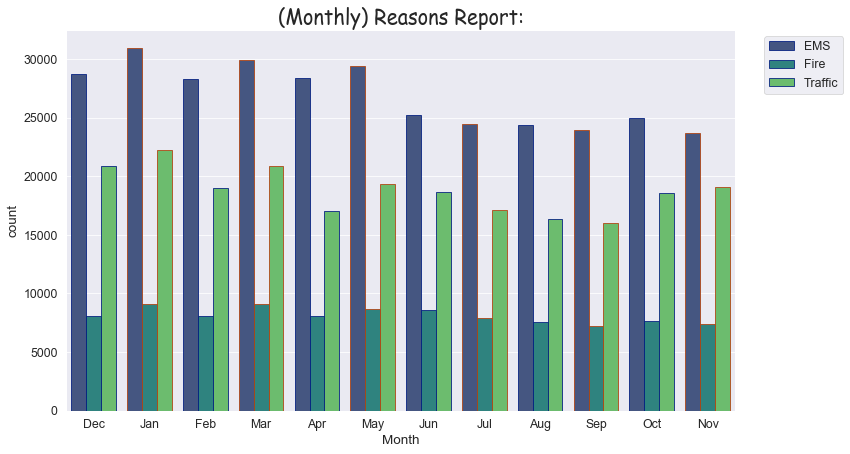

In [34]:
plt.title("(Monthly) Reasons Report:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(x=calls.Month, hue=calls.reason_type, edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);
plt.legend(bbox_to_anchor=(1.17, 1));

In [35]:
# -> Again, emergency calls are almost (equal) in all months. Also, (most) calls are in (January).
# -> Fewer calls during the Holiday Season (Jul, Aug and Sep).

#### QUESTION 8 – Most common (Reason) type, based on each (Hour)?

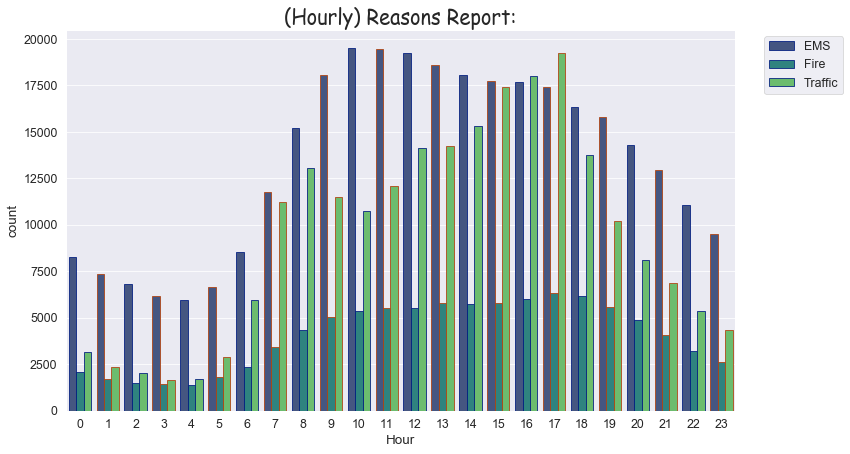

In [36]:
plt.title("(Hourly) Reasons Report:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(x=calls.Hour, hue=calls.reason_type, edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);
plt.legend(bbox_to_anchor=(1.17, 1));

In [37]:
# -> (Maximum) number of emergency calls happens at around 5PM (17:00).
# -> (Traffic) related problems are the (main) emergency. This may be due to people returning home from their work place at this time, and finding traffic jams, accidents due to signal jumpings etc.

#### QUESTION 9 – Top 10 (Incidents) reported for Calls?

In [38]:
calls["Incident"] = calls.title.apply(lambda x: x.split(":")[1])

top_10_incidents_reported = calls.Incident.value_counts()
print(top_10_incidents_reported.head(10))

 VEHICLE ACCIDENT -       145469
 DISABLED VEHICLE -        46786
 FIRE ALARM                37278
 VEHICLE ACCIDENT          35417
 FALL VICTIM               33529
 RESPIRATORY EMERGENCY     33336
 CARDIAC EMERGENCY         31475
 ROAD OBSTRUCTION -        22435
 SUBJECT IN PAIN           19092
 HEAD INJURY               17701
Name: Incident, dtype: int64


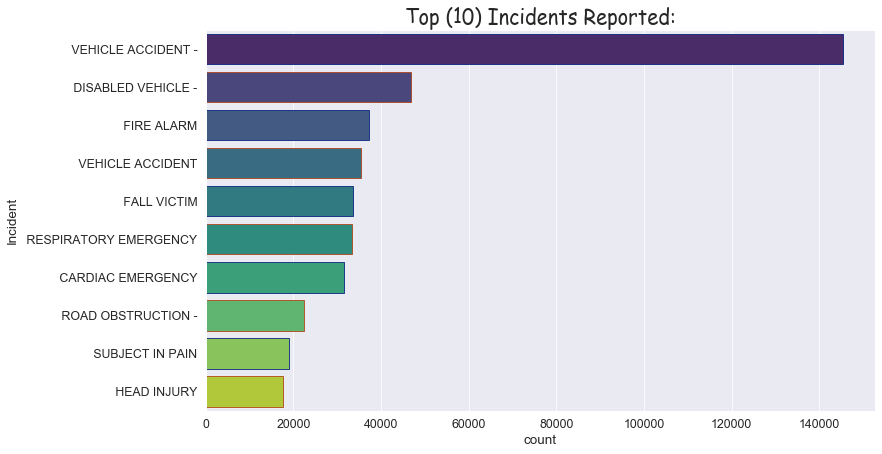

In [40]:
plt.title("Top (10) Incidents Reported:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(y=calls.Incident, order=top_10_incidents_reported.index[:10], edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);

In [41]:
# -> Most reported (incident) is 'Vehicle Accident' followed by 'Disabled Vehicle' then 'Fire Alarm'!

#### Dropped ['desc', 'title', 'timeStamp'], as all the (relevant) details have been (extracted) out of them.

In [42]:
calls.drop(["desc", "title", "timeStamp"], axis=1, inplace=True)

#### QUESTION 10 – (Frequency) of calls during Day/Night?

In [43]:
day_night = calls["Day/Night"].value_counts()
print(day_night)

Day      490137
Night    155061
Name: Day/Night, dtype: int64


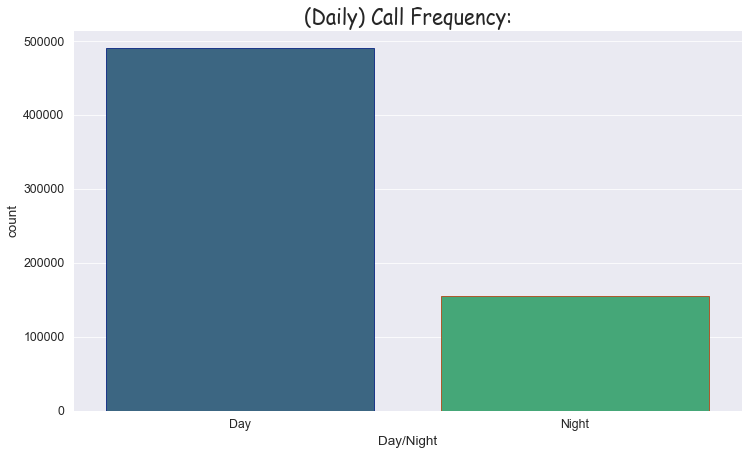

In [44]:
plt.title("(Daily) Call Frequency:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.countplot(calls["Day/Night"], edgecolor=sns.color_palette("dark", 2), palette="viridis", data=calls);

In [45]:
# -> Calls mostly occur throughout the Day rather than at Night!

#### QUESTION 11  – (EMS) calls per Day, across all (Years)?

In [46]:
ems_calls = calls[calls.reason_type == "EMS"].groupby("Date")["reason_type"].count()
print(ems_calls.head())

Date
2015-12-10     58
2015-12-11    186
2015-12-12    186
2015-12-13    188
2015-12-14    221
Name: reason_type, dtype: int64


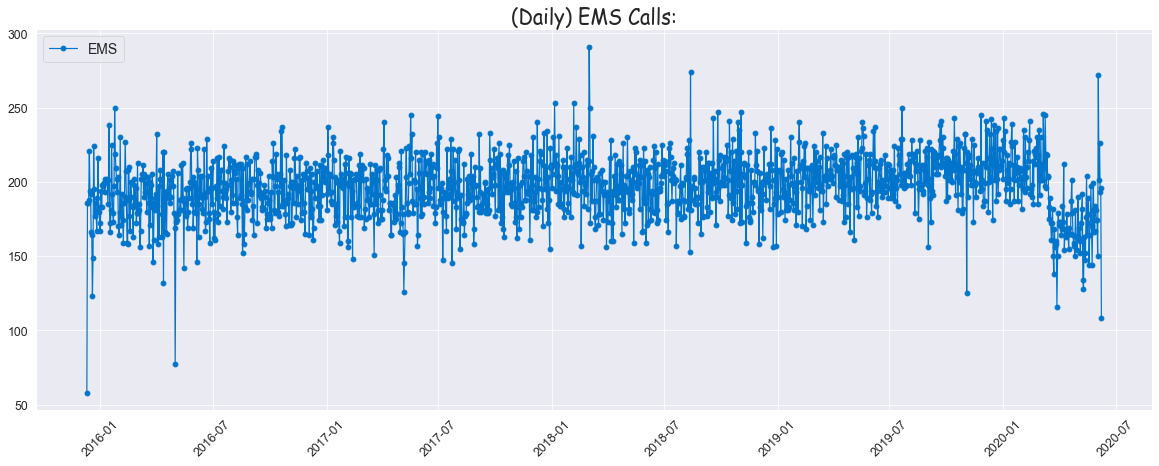

In [47]:
plt.figure(figsize=(20, 7))
plt.title("(Daily) EMS Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})

plt.plot(ems_calls, color="#0075CB", marker="o", label="EMS");
plt.xticks(rotation=45);
plt.legend(loc=2, prop={"size": 14});

#### QUESTION 12 – (Fire) calls per Day, across all (Years)?

In [48]:
fire_calls = calls[calls.reason_type == "Fire"].groupby("Date")["reason_type"].count()
print(fire_calls.head())

Date
2015-12-10    15
2015-12-11    68
2015-12-12    67
2015-12-13    50
2015-12-14    38
Name: reason_type, dtype: int64


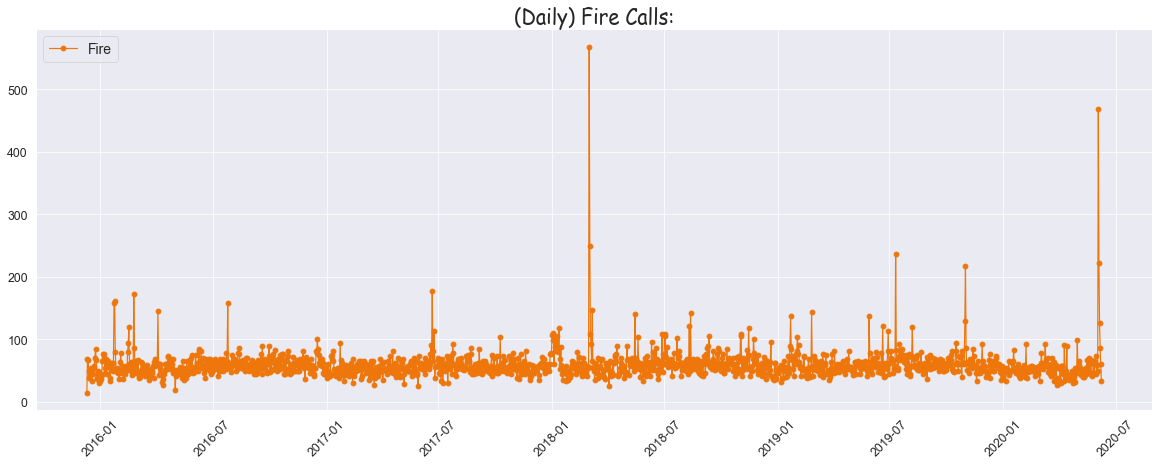

In [50]:
plt.figure(figsize=(20, 7))
plt.title("(Daily) Fire Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})

plt.plot(fire_calls, color="#EE760B", marker="o", label="Fire");
plt.xticks(rotation=45);
plt.legend(loc=2, prop={"size": 14});

#### QUESTION 13 – (Traffic) calls per Day, across all (Years)?

In [51]:
traffic_calls = calls[calls.reason_type == "Traffic"].groupby("Date")["reason_type"].count()
print(traffic_calls.head())

Date
2015-12-10     41
2015-12-11    137
2015-12-12    144
2015-12-13     72
2015-12-14    184
Name: reason_type, dtype: int64


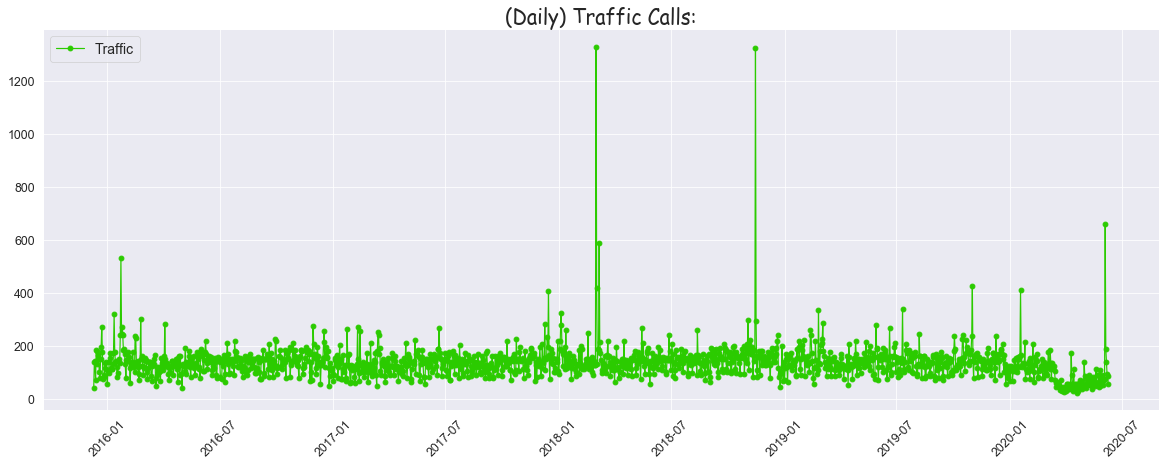

In [52]:
plt.figure(figsize=(20, 7))
plt.title("(Daily) Traffic Calls:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})

plt.plot(traffic_calls, color="#2BCB00", marker="o", label="Traffic");
plt.xticks(rotation=45);
plt.legend(loc=2, prop={"size": 14});

#### QUESTION 14 – Draw a Heatmap for each (Day)?

In [54]:
day_hour = calls.groupby(by=["DayOfWeek", "Hour"])["reason_type"].count().unstack()

# Solution 2: (use a pivot table).
calls.pivot_table(index="DayOfWeek", columns="Hour", values="reason_type", aggfunc="count")

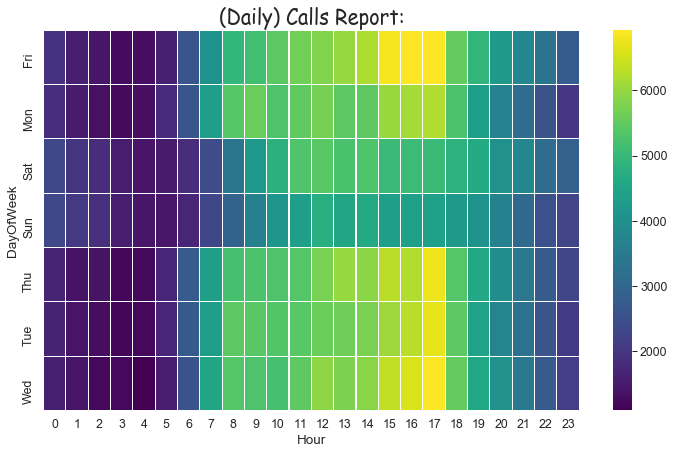

In [55]:
plt.title("(Daily) Calls Report:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.heatmap(day_hour, cmap="viridis", linewidths=0.1);

In [56]:
# -> Surge of calls on (Wednesday) and especially (Friday) between 15:00-17:00.
# -> More calls come in the (Evenings), but fewer during the (Night), and even less during the (Morning).
# -> Additionally, fewer calls on the weekends also.

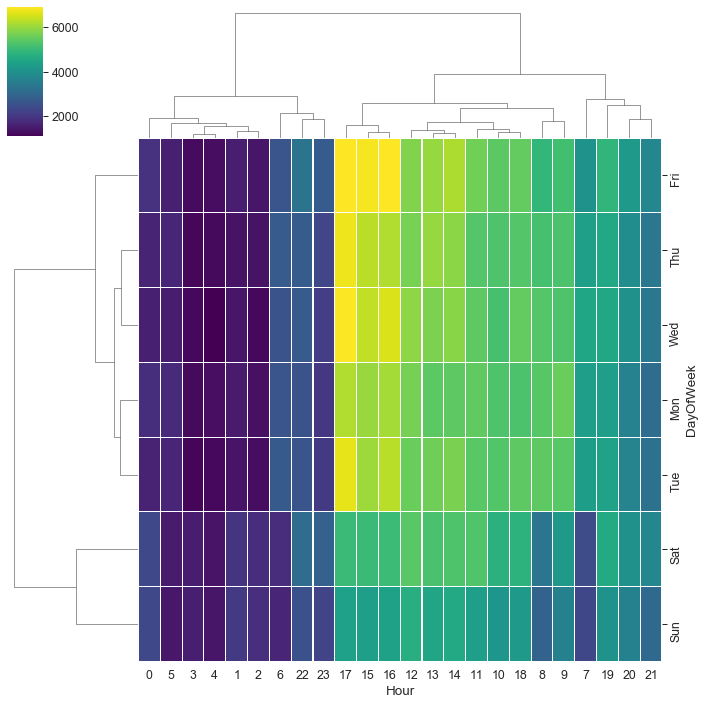

In [57]:
sns.clustermap(day_hour, cmap="viridis", linewidths=0.1);

#### QUESTION 15 – Draw a Heatmap for each (Month)?

In [60]:
day_month = calls.groupby(by=["DayOfWeek", "Month"])["reason_type"].count().unstack()

# Solution 2: (again, use a pivot table if it makes life easier).
calls.pivot_table(index="DayOfWeek", columns="Month", values="reason_type", aggfunc="count")

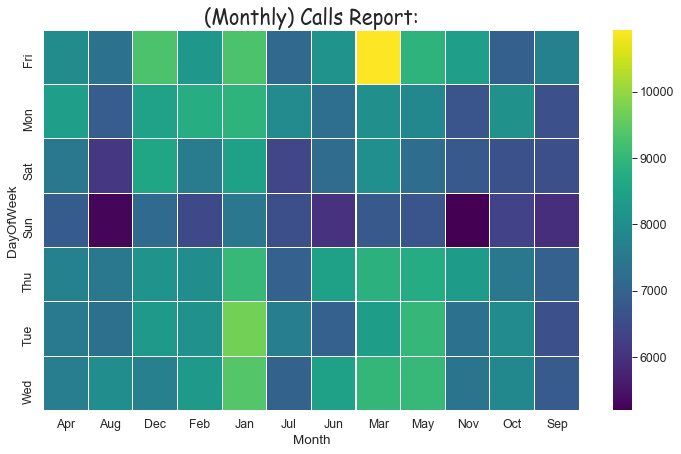

In [61]:
plt.title("(Monthly) Calls Report:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.heatmap(day_month, cmap="viridis", linewidths=0.1);

In [62]:
# -> Highest number of emergency calls is in (March) on Friday's.
# -> Least number of calls in (September), which is the (Safest) month throughout the Year.

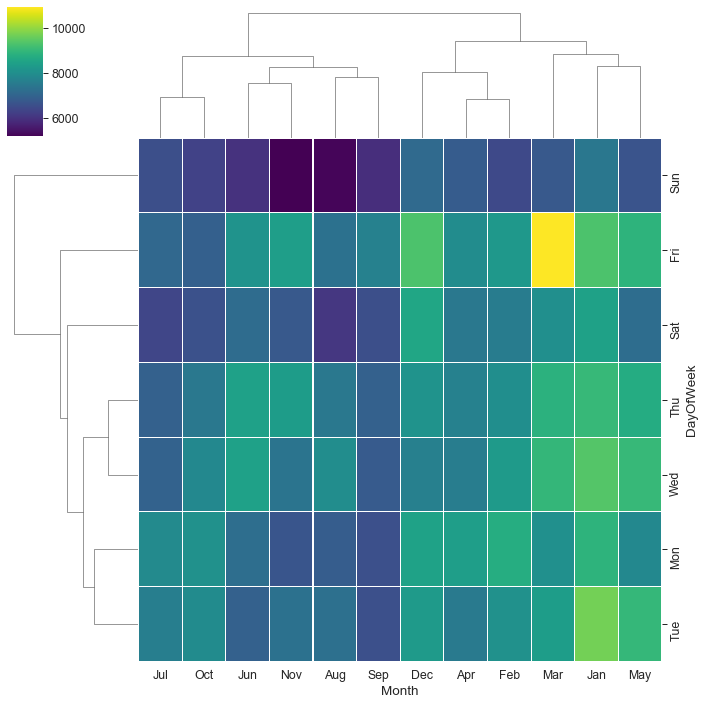

In [63]:
sns.clustermap(day_month, cmap="viridis", linewidths=0.1);

#### QUESTION 16 – Plot a Correlation Matrix? Correlation between Variables?

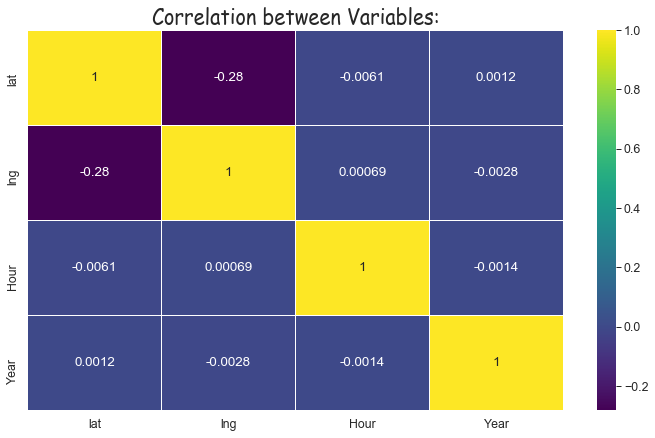

In [64]:
plt.title("Correlation between Variables:", fontdict={"fontsize":"20", "fontname":"Comic Sans MS"})
sns.heatmap(calls.corr(method="kendall"), annot=True, cmap="viridis", linewidths=0.1);

In [65]:
# -> No Strong correlation between (any) of the Variables.

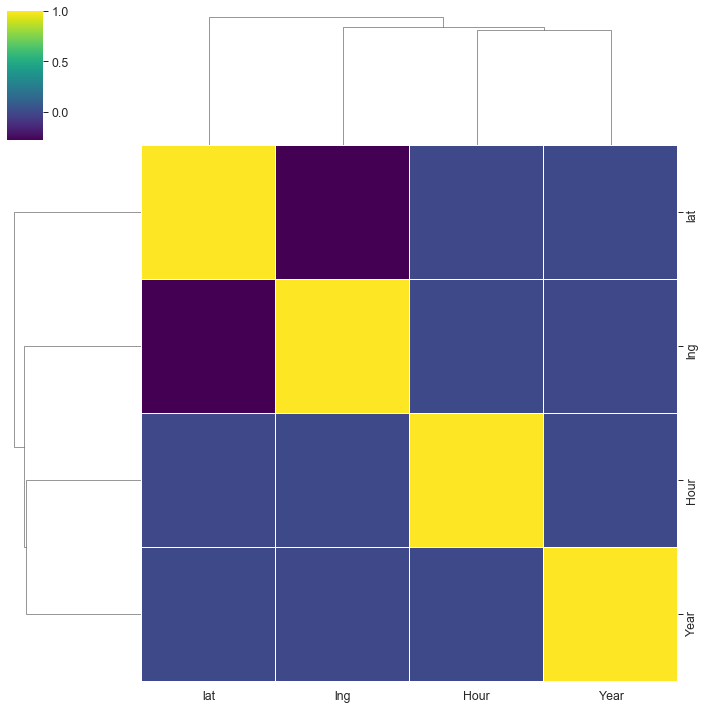

In [66]:
sns.clustermap(calls.corr(method="kendall"), cmap="viridis", linewidths=0.1);

### And this concludes the exploratory analysis project.